In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense, GRU
from tensorflow.keras.optimizers import SGD
import tensorflow as tf

In [44]:
dataset = pd.read_csv('ddos.csv')
df=pd.DataFrame(dataset) #dataframe dönüştürme
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [45]:
# çıkarılacak sütunların listesi
columns_to_drop = [
    ' Fwd Header Length.1', 'Flow Bytes/s', ' Flow Packets/s',
    'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
    ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
    'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags'
]
df = df.drop(columns=columns_to_drop) # sütunları çıkarma

In [46]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Flow IAT Mean', ' Flow IAT Std',
       ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean',
       ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total',
       ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',
       ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Co

In [47]:
data_f=df.dropna() # eksik verilerin çıkarılması
data_f[' Label'] = data_f[' Label'].map({'BENIGN': 0, 'DDoS': 1}) #sınıf etiketleri güncelleme

BENIGN sayısı: 97718
DDoS sayısı: 128027


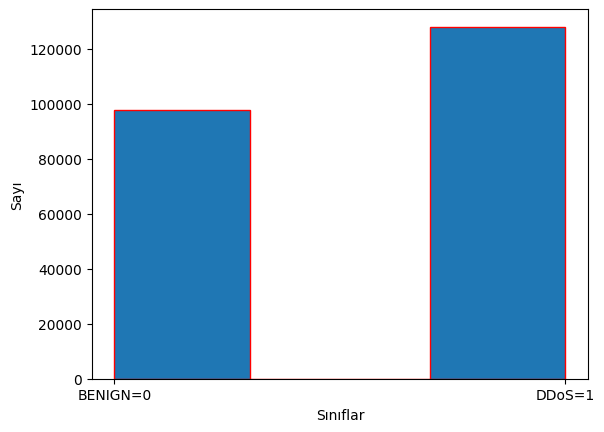

In [48]:
#sınıfların sayısının bulunması 
class_counts = data_f[' Label'].value_counts()
print("BENIGN sayısı:", class_counts[0])
print("DDoS sayısı:", class_counts[1])

plt.hist(data_f[' Label'], bins=[0, 0.3,0.7,1], edgecolor='red') 
plt.xticks([0, 1], labels=['BENIGN=0', 'DDoS=1'])
plt.xlabel("Sınıflar")
plt.ylabel("Sayı")
plt.show()


In [49]:
print(df.isnull().sum())  #eksik değer kontrolü
print(df[df.isin([np.inf, -np.inf]).any(1)])  #sonsuz değer kontrolü

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 66, dtype: int64


TypeError: DataFrame.any() takes 1 positional argument but 2 were given

In [50]:
# df.fillna(df.mean(numeric_only=True), inplace=True) #ortalama değerle doldurma

In [51]:
# print(df.isnull().sum())  

In [52]:
#özellik ölçeklendirme ve normalize
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
X_normalized = scaler.fit_transform(df[[' Destination Port',' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       ' Total Length of Bwd Packets','Total Length of Fwd Packets', ' Fwd Packet Length Mean',' Bwd Packet Length Mean',
       ' Flow IAT Mean', ' Fwd IAT Mean', 'Fwd Packets/s',' Bwd Packets/s',]])

label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df[' Label'])

In [53]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) #cross val

#değerlendirme metrikleri için boş listeler
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []


In [54]:
for train_index, test_index in kf.split(X_normalized):
    X_train_fold, X_test_fold = X_normalized[train_index], X_normalized[test_index]
    y_train_fold, y_test_fold = df['Category_encoded'][train_index], df['Category_encoded'][test_index]
    
    #MLP modelinin oluşturulması
    model_MLP = Sequential()
    model_MLP.add(Dense(128, activation='relu', input_shape=(X_train_fold.shape[1],)))
    model_MLP.add(Dropout(0.5))
    model_MLP.add(Dense(64, activation='relu'))
    model_MLP.add(Dropout(0.5))
    model_MLP.add(Dense(1, activation='sigmoid'))

    #öğrenme hızı belirleyerek optimizer oluşturma
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)

    #derleme
    model_MLP.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    #modeli erken durdurma ile eğitme
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model_MLP.fit(X_train_fold, y_train_fold, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    
    #test seti üzerinde değerlendirme
    y_pred_fold = model_MLP.predict(X_test_fold)
    y_pred_binary_fold = (y_pred_fold > 0.5).astype(int)

    #metrik hesaplama
    accuracy_fold = accuracy_score(y_test_fold, y_pred_binary_fold)
    precision_fold = precision_score(y_test_fold, y_pred_binary_fold)
    recall_fold = recall_score(y_test_fold, y_pred_binary_fold)
    f1_fold = f1_score(y_test_fold, y_pred_binary_fold)
    conf_matrix_fold = confusion_matrix(y_test_fold, y_pred_binary_fold)
    
    #listeye ekleme
    accuracy_scores.append(accuracy_fold)
    precision_scores.append(precision_fold)
    recall_scores.append(recall_fold)
    f1_scores.append(f1_fold)
    conf_matrices.append(conf_matrix_fold)

C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step


In [55]:
#her fold için ortalama değer hesaplama
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_conf_matrix = np.mean(conf_matrices, axis=0)

print(f'Average Accuracy (MLP - Cross Validation): {avg_accuracy}')
print(f'Average Precision (MLP - Cross Validation): {avg_precision}')
print(f'Average Recall (MLP - Cross Validation): {avg_recall}')
print(f'Average F1 Score (MLP - Cross Validation): {avg_f1}')
print('Confusion Matrix (MLP - Cross Validation):')
print(avg_conf_matrix)

Average Accuracy (MLP - Cross Validation): 0.9984185696250194
Average Precision (MLP - Cross Validation): 0.9984612383157208
Average Recall (MLP - Cross Validation): 0.9987500093263441
Average F1 Score (MLP - Cross Validation): 0.9986054558951885
Confusion Matrix (MLP - Cross Validation):
[[19504.2    39.4]
 [   32.  25573.4]]


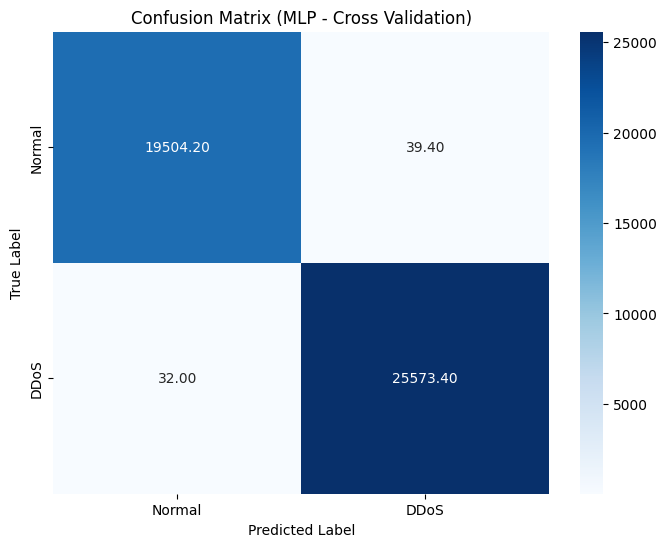

In [56]:
# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'])
plt.title('Confusion Matrix (MLP - Cross Validation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [57]:
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_scores_rnn = []
precision_scores_rnn = []
recall_scores_rnn = []
f1_scores_rnn = []
conf_matrices_rnn = []

In [58]:
for train_index, test_index in kf.split(X_normalized): #X_normalized veri setine n katına böler
    X_train_fold, X_test_fold = X_normalized[train_index], X_normalized[test_index]
    y_train_fold, y_test_fold = df['Category_encoded'][train_index], df['Category_encoded'][test_index]
    
    X_train_rnn_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1) #3 boyutlu hale dönüştürülür
    X_test_rnn_fold = X_test_fold.reshape(X_test_fold.shape[0], X_test_fold.shape[1], 1)
    
    model_RNN = Sequential()
    model_RNN.add(SimpleRNN(64, activation='relu', input_shape=(X_train_rnn_fold.shape[1], 1)))
    model_RNN.add(Dropout(0.2)) #bu katman belirli nöronları rastgele kapatarak aşırı öğrenmeyi önler.
    model_RNN.add(Dense(64, activation='relu'))
    model_RNN.add(Dropout(0.5))
    model_RNN.add(Dense(1, activation='sigmoid')) #çıkış katmanı

    learning_rate = 0.001
    optimizer = SGD(learning_rate=learning_rate)

    model_RNN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #val_loss belirli bir süre boyunca iyileşmezse eğitimi durdurur ve en iyi ağırlıkları geri yükler.

    model_RNN.fit(X_train_rnn_fold, y_train_fold, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    
    y_pred_rnn_fold = model_RNN.predict(X_test_rnn_fold)
    y_pred_binary_rnn_fold = (y_pred_rnn_fold > 0.5).astype(int) #eşik değeri kullanılarak ikili değerlere dönüştürülür.

    accuracy_fold_rnn = accuracy_score(y_test_fold, y_pred_binary_rnn_fold)
    precision_fold_rnn = precision_score(y_test_fold, y_pred_binary_rnn_fold)
    recall_fold_rnn = recall_score(y_test_fold, y_pred_binary_rnn_fold)
    f1_fold_rnn = f1_score(y_test_fold, y_pred_binary_rnn_fold)
    conf_matrix_fold_rnn = confusion_matrix(y_test_fold, y_pred_binary_rnn_fold)
    
    accuracy_scores_rnn.append(accuracy_fold_rnn)
    precision_scores_rnn.append(precision_fold_rnn)
    recall_scores_rnn.append(recall_fold_rnn)
    f1_scores_rnn.append(f1_fold_rnn)
    conf_matrices_rnn.append(conf_matrix_fold_rnn)

C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [59]:
avg_accuracy_rnn = np.mean(accuracy_scores_rnn)
avg_precision_rnn = np.mean(precision_scores_rnn)
avg_recall_rnn = np.mean(recall_scores_rnn)
avg_f1_rnn = np.mean(f1_scores_rnn)
avg_conf_matrix_rnn = np.mean(conf_matrices_rnn, axis=0)

print(f'Average Accuracy (RNN - Cross Validation): {avg_accuracy_rnn}')
print(f'Average Precision (RNN - Cross Validation): {avg_precision_rnn}')
print(f'Average Recall (RNN - Cross Validation): {avg_recall_rnn}')
print(f'Average F1 Score (RNN - Cross Validation): {avg_f1_rnn}')
print('Confusion Matrix (RNN - Cross Validation):')
print(avg_conf_matrix_rnn)

Average Accuracy (RNN - Cross Validation): 0.983835743870296
Average Precision (RNN - Cross Validation): 0.9737324638785386
Average Recall (RNN - Cross Validation): 0.9984552005085952
Average F1 Score (RNN - Cross Validation): 0.9859344546977376
Confusion Matrix (RNN - Cross Validation):
[[18853.4   690.2]
 [   39.6 25565.8]]


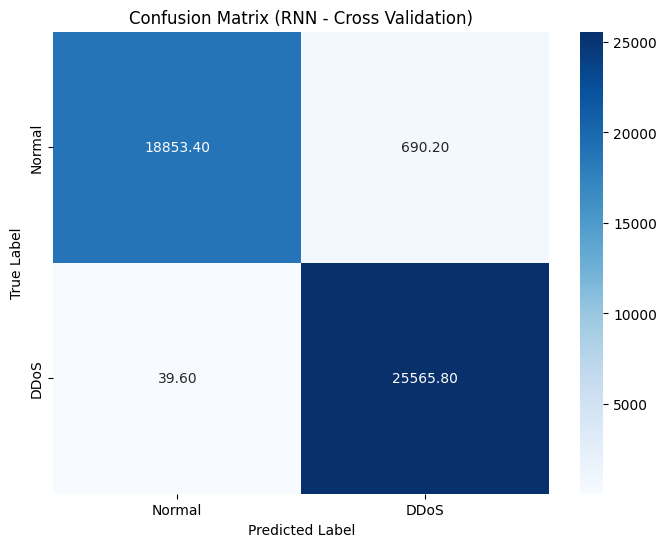

In [60]:
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix_rnn, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'])
plt.title('Confusion Matrix (RNN - Cross Validation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [61]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_scores_cnn = []
precision_scores_cnn = []
recall_scores_cnn = []
f1_scores_cnn = []
conf_matrices_cnn = []

In [62]:
for train_index, test_index in kf.split(X_normalized):
    X_train_fold, X_test_fold = X_normalized[train_index], X_normalized[test_index]
    y_train_fold, y_test_fold = df['Category_encoded'][train_index], df['Category_encoded'][test_index]

    X_train_cnn_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_test_cnn_fold = X_test_fold.reshape(X_test_fold.shape[0], X_test_fold.shape[1], 1)

    model_CNN = Sequential()
    model_CNN.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn_fold.shape[1], 1)))
    model_CNN.add(Dropout(0.2))
    model_CNN.add(Conv1D(128, kernel_size=3, activation='relu'))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(64, activation='relu'))
    model_CNN.add(Dropout(0.5))
    model_CNN.add(Dense(1, activation='sigmoid'))

    learning_rate = 0.001
    optimizer = SGD(learning_rate=learning_rate)

    model_CNN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model_CNN.fit(X_train_cnn_fold, y_train_fold, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    
    y_pred_cnn_fold = model_CNN.predict(X_test_cnn_fold)
    y_pred_binary_cnn_fold = (y_pred_cnn_fold > 0.5).astype(int)

    accuracy_fold_cnn = accuracy_score(y_test_fold, y_pred_binary_cnn_fold)
    precision_fold_cnn = precision_score(y_test_fold, y_pred_binary_cnn_fold)
    recall_fold_cnn = recall_score(y_test_fold, y_pred_binary_cnn_fold)
    f1_fold_cnn = f1_score(y_test_fold, y_pred_binary_cnn_fold)
    conf_matrix_fold_cnn = confusion_matrix(y_test_fold, y_pred_binary_cnn_fold)
    
    accuracy_scores_cnn.append(accuracy_fold_cnn)
    precision_scores_cnn.append(precision_fold_cnn)
    recall_scores_cnn.append(recall_fold_cnn)
    f1_scores_cnn.append(f1_fold_cnn)
    conf_matrices_cnn.append(conf_matrix_fold_cnn)

C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


C:\Users\erogl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [63]:
avg_accuracy_cnn = np.mean(accuracy_scores_cnn)
avg_precision_cnn = np.mean(precision_scores_cnn)
avg_recall_cnn = np.mean(recall_scores_cnn)
avg_f1_cnn = np.mean(f1_scores_cnn)
avg_conf_matrix_cnn = np.mean(conf_matrices_cnn, axis=0)

print(f'Average Accuracy (CNN - Cross Validation): {avg_accuracy_cnn}')
print(f'Average Precision (CNN - Cross Validation): {avg_precision_cnn}')
print(f'Average Recall (CNN - Cross Validation): {avg_recall_cnn}')
print(f'Average F1 Score (CNN - Cross Validation): {avg_f1_cnn}')
print('Confusion Matrix (CNN - Cross Validation):')
print(avg_conf_matrix_cnn)

Average Accuracy (CNN - Cross Validation): 0.9412124299541518
Average Precision (CNN - Cross Validation): 0.948727072099504
Average Recall (CNN - Cross Validation): 0.9475489514687719
Average F1 Score (CNN - Cross Validation): 0.94813006205557
Confusion Matrix (CNN - Cross Validation):
[[18232.6  1311. ]
 [ 1343.2 24262.2]]


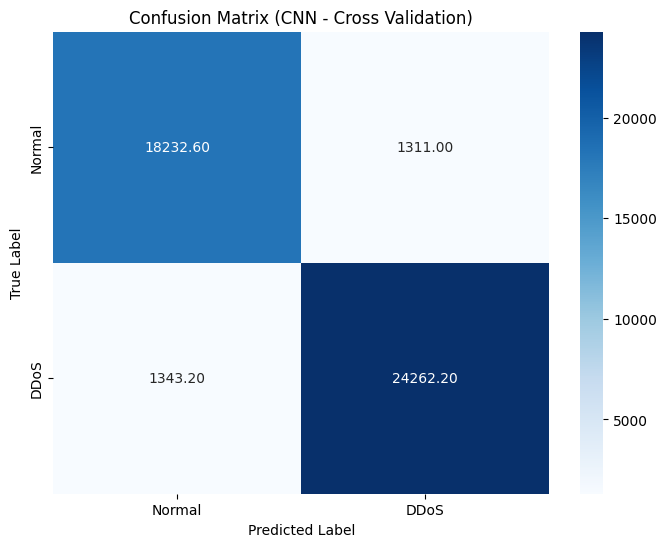

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix_cnn, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'])
plt.title('Confusion Matrix (CNN - Cross Validation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()